In [1]:
from __future__ import annotations
import os, time, math, sys
os.environ['OMP_NUM_THREADS']='1'
os.environ['MKL_NUM_THREADS']='1'
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['VECLIB_MAXIMUM_THREADS']='1'
os.environ['NUMEXPR_NUM_THREADS']='1'
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path


# Ensure local src/ on sys.path when run as a script
_HERE = Path("transmission_parametric_sinw").resolve().parent
_SRC = _HERE.parent.parent  # .../src

if str(_SRC) not in sys.path:
    sys.path.insert(0, str(_SRC))

from hamiltonian import Hamiltonian
from hamiltonian.base.block_tridiagonalization import split_into_subblocks_optimized
from hamiltonian.geometry.grid_mapping import atomistic_to_grid_ham
from negf.gf.recursive_greens_functions import gf_inverse
from negf.self_energy import greens_functions
from hamiltonian.tb.orbitals import Orbitals

from negf.gf.functions import GFFunctions

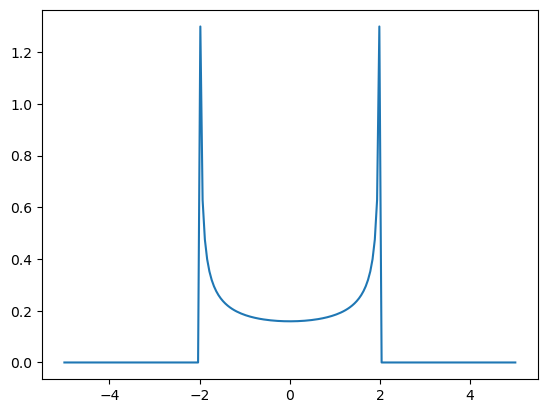

In [2]:
Orbitals.orbital_sets = {"Base": "Base"}
N = 12
hamiltonian = Hamiltonian(structure = "line",nx=N, ny=0, nz=0, periodic_dirs='x', passivate_x=False, nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport', sparse_build = False, return_sparse=False)
hamiltonian.initialize()
ham_new, hL0, hLC, hR0, hRC, _ = hamiltonian.determine_leads()
GF = GFFunctions(hamiltonian, energy_grid=np.linspace(-5,5, 200))
dos = GF.total_dos(processes=32) 
plt.plot(GF.energy_grid, dos / N)
Y = GF.get_n(np.zeros(N), np.zeros(N),processes=32)


In [3]:
X = GF.fermi_level(np.zeros((hamiltonian.nx, )), -2, 2, False)

In [4]:
atomistic_to_grid_ham(hamiltonian, X, (20, ), combine="max")

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [6]:
print(Y)

[0.00267886 0.00267886 0.00267886 0.00267886 0.00267886 0.00267886
 0.00267886 0.00267886 0.00267886 0.00267886 0.00267886 0.00267886]


In [14]:

Orbitals.orbital_sets = {"Si": "SiliconSP3D5S", "H": "HydrogenS"}
# Parametric nanowire generator parameters
a_si = 5.50
hamiltonian = Hamiltonian(nx=8, ny=1, nz=1, a=a_si, periodic_dirs='', passivate_x=False, nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport', sparse_build = False, return_sparse=False)
hamiltonian.initialize()
# Debug: print atom order as in matrix (index, label, position, DOF range)
ordered_atoms = list(hamiltonian.atom_list.items())
for idx, (label, pos) in enumerate(ordered_atoms):
    x, y, z = (float(pos[0]), float(pos[1]), float(pos[2]))
    s, e = int(GF.atom_offsets[idx]), int(GF.atom_offsets[idx+1])
    print(f"{idx:4d}: {label:>8s}  pos = [{x: .6f}, {y: .6f}, {z: .6f}]  DOF[{s}:{e})")
# h0 is already the principal layer onsite from determine_leads

# # Visualize sparsity patterns
# fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# axs[0].spy(hamiltonian.h_matrix, markersize=1); axs[0].set_title('h0')
# # axs[1].spy(hl, markersize=1); axs[1].set_title('hl (right->left)')
# # axs[2].spy(hr, markersize=1); axs[2].set_title('hr (left->right)')
# for ax in axs:
#     ax.set_xlabel('Col'); ax.set_ylabel('Row')
# plt.tight_layout(); plt.show()

   0:      Si1  pos = [ 0.000000,  0.000000,  0.000000]  DOF[0:10)
   1:      Si2  pos = [ 0.000000,  0.000000,  5.500000]  DOF[10:20)
   2:      Si3  pos = [ 0.000000,  2.750000,  2.750000]  DOF[20:30)
   3:      Si4  pos = [ 0.000000,  5.500000,  0.000000]  DOF[30:40)
   4:      Si5  pos = [ 0.000000,  5.500000,  5.500000]  DOF[40:50)
   5:       H1  pos = [ 0.859375, -0.859375, -0.859375]  DOF[50:51)
   6:       H2  pos = [ 0.859375, -0.859375,  4.640625]  DOF[51:52)
   7:       H3  pos = [ 0.859375,  0.859375,  6.359375]  DOF[52:53)
   8:       H4  pos = [ 0.859375,  4.640625, -0.859375]  DOF[53:54)
   9:       H5  pos = [ 0.859375,  6.359375,  0.859375]  DOF[54:55)
  10:       H6  pos = [ 0.859375,  6.359375,  6.359375]  DOF[55:56)
  11:      Si6  pos = [ 1.375000,  1.375000,  1.375000]  DOF[56:66)
  12:      Si7  pos = [ 1.375000,  4.125000,  4.125000]  DOF[66:76)
  13:       H7  pos = [ 1.890625, -0.859375,  3.609375]  DOF[76:77)
  14:       H8  pos = [ 1.890625,  1.890625,  6.3

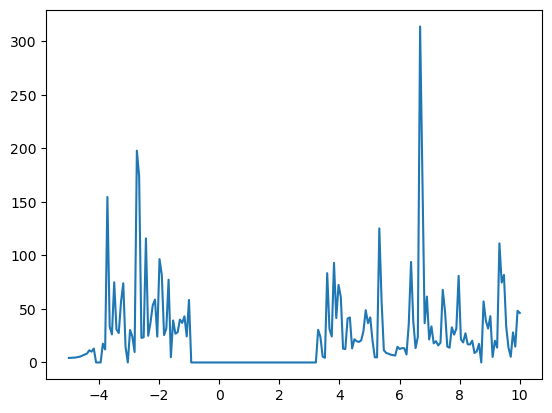

In [15]:
GF = GFFunctions(hamiltonian, energy_grid=np.linspace(-5, 10, 200))
dos = GF.total_dos(processes=32)   # now should work
plt.plot(GF.energy_grid, dos)

In [19]:
x= GF.compute_charge_density(processes=32)
print(x)
print(len(x))

[0.86498266 0.74415964 0.92862133 0.74415964 0.86498266 0.40486842
 0.34929098 0.34929098 0.34929098 0.34929098 0.40486842 0.96462954
 0.96462954 0.32711542 0.32711542 0.32711542 0.32711542 0.80225738
 0.80225738 0.80225738 0.80225738 0.35883096 0.35883096 0.35883096
 0.35883096 0.97729945 0.97729945 0.33142148 0.23521351 0.33142148
 0.33142148 0.23521351 0.33142148 0.74748326 0.65714563 1.09158
 0.65714563 0.74748326 0.35120321 0.31014335 0.31014335 0.31014335
 0.31014335 0.35120321 1.038217   1.038217   0.37681688 0.37681688
 0.37681688 0.37681688 0.81550224 0.81550224 0.81550224 0.81550224
 0.33101404 0.33101404 0.33101404 0.33101404 0.92292906 0.92292906
 0.33746551 0.27900486 0.33746551 0.33746551 0.27900486 0.33746551
 0.6329747  0.65210687 0.89966684 0.65210687 0.6329747  0.22858867
 0.25528881 0.25528881 0.25528881 0.25528881 0.22858867 0.82966835
 0.82966835 0.23184099 0.23184099 0.23184099 0.23184099 0.56137592
 0.56137592 0.56137592 0.56137592 0.23705848 0.23705848 0.2370584

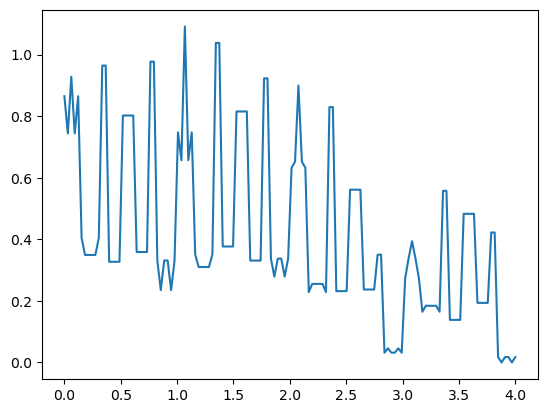

In [16]:
plt.plot(np.linspace(0, 4, 132), x)

In [11]:
GF.fermi_level(V = np.zeros((132,)), lower_bound= -1 *np.ones((132,)), upper_bound= 3 *np.ones((132,)), processes=  32)

KeyboardInterrupt: 

In [ ]:
ham_new, hL0, hLC, hR0, hRC = hamiltonian.determine_leads()

In [ ]:
import negf.self_energy.surface as suface

In [ ]:
import scipy.sparse as sp
H = sp.csc_matrix(hamiltonian.h_matrix)


In [ ]:
eigenvalues, eigenvectors = sp.linalg.eigsh(H, k=100, sigma=0.6, which='LM')

In [ ]:
print(sorted(eigenvalues))

In [ ]:
GF = GFFunctions(hamiltonian, energy_grid=np.linspace(-5, 10, 200))
dos = GF.total_dos(processes=32)   # now should work
plt.plot(GF.energy_grid, dos)

In [ ]:
GF = GFFunctions(hamiltonian, energy_grid=np.linspace(-5, 10, 200))
trans = GF.transmission(processes=32)   # now should work
plt.plot(GF.energy_grid, trans)

In [ ]:
# Build lead principal-layer blocks
ham_new, hL0, hLC, hR0, hRC = hamiltonian.get_hamiltonians()

# For NEGF, use the device-only Hamiltonian; self-energies are added to its boundary DOFs
Hdev = hamiltonian.h_matrix

fig, axs = plt.subplots(1, 3, figsize=(15, 4))
axs[0].spy(hL0, markersize=1); axs[0].set_title('Lead onsite H00')
axs[1].spy(hLC, markersize=1); axs[1].set_title('Lead coupling H01 (→ right)')
axs[2].spy(Hdev, markersize=0.5); axs[2].set_title('Device Hamiltonian Hdev')
for ax in axs:
    ax.set_xlabel('Col'); ax.set_ylabel('Row')
plt.tight_layout(); plt.show()

In [ ]:
hamiltonian_ = Hamiltonian(nx=3, ny=1, nz=2, a=a_si, periodic_dirs='xy', passivate_x=True, nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport')
hamiltonian_.initialize()
evals = np.linalg.eigvals(hamiltonian_.h_matrix)
for i in np.sort(np.real(evals)):
    print(i)

In [ ]:
def _sancho_rubio_surface_gf(E, H00, H01, S00=None, iter_max=200, TOL=1e-12):
    """
    Jiezi surface_gf algorithm translated to use numpy arrays.
    Returns surface Green's function G00 for a semi-infinite lead with onsite H00 and coupling H01 (to the right neighbor).
    """
    E = E + 1e-3j
    n = H00.shape[0]
    I = np.eye(n, dtype=complex)
    S00 = I if S00 is None else S00
    # Convert to dense if needed
    if hasattr(H00, 'toarray'): H00 = H00.toarray()
    if hasattr(H01, 'toarray'): H01 = H01.toarray()
    if hasattr(S00, 'toarray'): S00 = S00.toarray()

    iter_c = 0
    H10 = H01.conj().T
    alpha = H10.copy()   # coupling to the left
    beta  = H01.copy()   # coupling to the right
    epsilon = H00.copy()
    epsilon_s = H00.copy()
    Eeye = I * E

    while iter_c < iter_max:
        iter_c += 1
        inv_term = np.linalg.solve(Eeye - epsilon, I)
        alpha_new = alpha @ inv_term @ alpha
        beta_new  = beta  @ inv_term @ beta
        epsilon_new   = epsilon   + alpha @ inv_term @ beta + beta @ inv_term @ alpha
        epsilon_s_new = epsilon_s + alpha @ inv_term @ beta
        if np.linalg.norm(alpha_new, ord='fro') < TOL and np.linalg.norm(beta_new, ord='fro') < TOL:
            G00 = np.linalg.solve(Eeye - epsilon_s_new, I)
            break
        alpha, beta = alpha_new, beta_new
        epsilon, epsilon_s = epsilon_new, epsilon_s_new
    else:
        print(f"Warning: Surface GF did not converge after {iter_max} iterations")
        G00 = np.linalg.solve(Eeye - epsilon_s, I)
    return G00

In [ ]:
energy = np.linspace(-5, 10, 200)
damp = 0.00001j
tr = np.zeros(energy.shape)
dos = np.zeros(energy.shape)
traces_L = []
traces_R = []

# Use identical principal-layer lead definition on both sides (orientation to the right)
H00 = hL0
H01 = hLC

In [ ]:
G_R_diag, G_lesser_diag, Gamma_L, Gamma_R= gf_inverse(6, ham_new, H00, H01,block_size=150, method="direct")
print(np.sum(G_R_diag))

In [ ]:
H00.shape

In [ ]:

# For embedding, use device-lead coupling T; in a uniform setup we can take T = H01
T_L = H01
T_R = H01

# Quick sanity checks
print('||H00_L - H00_R||_max ~ 0? ', np.max(np.abs(H00 - H00)))
print('||H01_L - H01_R||_max ~ 0? ', np.max(np.abs(H01 - H01)))



for j, E in enumerate(energy):
    # Surface GFs per side (identical leads)
    G_R_diag, G_lesser_diag, Gamma_L, Gamma_R,_= gf_inverse(E, ham_new, H00, H01,block_size=446, method="recursive")
    dos[j] = -1 / np.pi * np.imag(np.sum(G_R_diag))



In [ ]:
plt.plot(energy, dos)

In [ ]:
G00_L = _sancho_rubio_surface_gf(E, H00, H01)
G00_L

In [ ]:
np.trace(H01 @ G00_L @ H01.T.conj())

In [ ]:
# Diagnostics: verify left/right lead definitions are identical
print('Lead onsite Hermitian? ', np.allclose(hL0, hL0.conj().T, atol=1e-10))
print('Right onsite Hermitian? ', np.allclose(hR0, hR0.conj().T, atol=1e-10))
print('||hL0 - hR0||_max =', float(np.max(np.abs(hL0 - hR0))))
print('||hLC - hRC.conj().T||_max =', float(np.max(np.abs(hLC - hRC.conj().T))))
E0 = 1.2
G00_ref = _sancho_rubio_surface_gf(E0, hL0, hLC)
Sigma_ref = hLC.conj().T @ G00_ref @ hLC
G00_L = _sancho_rubio_surface_gf(E0, hL0, hLC)
G00_R = _sancho_rubio_surface_gf(E0, hR0, hLC)
Sigma_L = hLC.conj().T @ G00_L @ hLC
Sigma_R = hLC.conj().T @ G00_R @ hLC
print('Test E0 =', E0)
print('||Sigma_ref - Sigma_L||_max =', float(np.max(np.abs(Sigma_ref - Sigma_L))))
print('||Sigma_L - Sigma_R||_max =', float(np.max(np.abs(Sigma_L - Sigma_R))))
print('trace(Sigma_L)=', complex(np.trace(Sigma_L)))
print('trace(Sigma_R)=', complex(np.trace(Sigma_R)))

In [ ]:
# Build periodic-in-x lead blocks (H00, H01) from a separate 2-cell supercell
# Keep the device region (current hamiltonian) open in x; only the leads are periodic.

# 1) Construct a periodic-in-x nanowire used only to define leads
Orbitals.orbital_sets = {"Si": "SiliconSP3D5S", "H": "HydrogenS"}
a_si = 5.50
lead_builder = Hamiltonian(nx=2, ny=1, nz=1, a=a_si,
                           periodic_dirs='x', passivate_x=False,  # periodic in x removes surface along transport
                           nn_distance=2.4, transport_dir=[1,0,0], sort_axis='transport')
lead_builder.initialize()
Hlead = lead_builder.h_matrix

# 2) Extract principal-layer onsite/coupling blocks from the periodic supercell
m = Hlead.shape[0] // 2
H00_p = Hlead[:m, :m]
H01_p = Hlead[:m, m:2*m]

# Sanity: Hermiticity and expected conjugacy
print('Periodic lead H00 Hermitian? ', np.allclose(H00_p, H00_p.conj().T, atol=1e-10))
print('Interface conjugacy near-zero? ', np.max(np.abs(H01_p.conj().T - Hlead[m:2*m, :m])) < 1e-10)

# 3) Recompute self-energies with periodic leads and embed into existing extended Hamiltonian ham_new
energy_p = np.linspace(0, 1.75, 50)
traces_L_p, traces_R_p, dos_p = [], [], []

for E in energy_p:
    G00_Lp = _sancho_rubio_surface_gf(E, H00_p, H01_p)
    G00_Rp = _sancho_rubio_surface_gf(E, H00_p, H01_p)
    Sigma_Lp = H01_p.conj().T @ G00_Lp @ H01_p
    Sigma_Rp = H01_p.conj().T @ G00_Rp @ H01_p

    traces_L_p.append(np.trace(Sigma_Lp))
    traces_R_p.append(np.trace(Sigma_Rp))

    # Embed into corners of ham_new
    Lp_ = np.zeros_like(ham_new); m0 = Sigma_Lp.shape[0]; Lp_[:m0, :m0] = Sigma_Lp
    Rp_ = np.zeros_like(ham_new); Rp_[-m0:, -m0:] = Sigma_Rp

    A = (E + 1e-9j) * np.eye(ham_new.shape[0], dtype=complex) - (ham_new + Lp_ + Rp_)
    Gr = np.linalg.solve(A, np.eye(ham_new.shape[0], dtype=complex))
    dos_p.append(-1/np.pi * np.imag(np.trace(Gr)))

traces_L_p = np.array(traces_L_p)
traces_R_p = np.array(traces_R_p)
dos_p = np.array(dos_p)

# 4) Plot: compare previous vs periodic-lead results
fig, ax = plt.subplots(3, 1, figsize=(7,8), sharex=True)
ax[0].plot(energy, dos, 'k', label='DOS (prev)')
ax[0].plot(energy_p, dos_p, 'g--', label='DOS (periodic leads)')
ax[0].legend(loc='best'); ax[0].set_ylabel('DOS (a.u)')

ax[1].plot(energy, np.real(traces_L), 'b', label='Re Tr(Σ_L) prev')
ax[1].plot(energy, np.real(traces_R), 'r--', label='Re Tr(Σ_R) prev')
ax[1].plot(energy_p, np.real(traces_L_p), 'c', label='Re Tr(Σ_L) periodic')
ax[1].plot(energy_p, np.real(traces_R_p), 'm--', label='Re Tr(Σ_R) periodic')
ax[1].legend(loc='best'); ax[1].set_ylabel('Re trace')

ax[2].plot(energy, np.imag(traces_L), 'b', label='Im Tr(Σ_L) prev')
ax[2].plot(energy, np.imag(traces_R), 'r--', label='Im Tr(Σ_R) prev')
ax[2].plot(energy_p, np.imag(traces_L_p), 'c', label='Im Tr(Σ_L) periodic')
ax[2].plot(energy_p, np.imag(traces_R_p), 'm--', label='Im Tr(Σ_R) periodic')
ax[2].legend(loc='best'); ax[2].set_ylabel('Im trace')
ax[2].set_xlabel('Energy (eV)')
fig.tight_layout(); plt.show()

# 5) Lead spectral function check (should be ~0 in the gap for periodic leads)
A_lead = [-np.imag(np.trace(_sancho_rubio_surface_gf(E, H00_p, H01_p)))/np.pi for E in energy_p]
plt.figure(figsize=(6,3))
plt.plot(energy_p, A_lead)
plt.ylabel('Lead spectral trace')
plt.xlabel('Energy (eV)')
plt.title('Periodic lead surface spectral density')
plt.tight_layout(); plt.show()